In [9]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.visualization import circuit_drawer

# --- Example Parameters (if not already defined) ---
from qiskit.circuit.library import TwoLocal

# Build the encoder circuit (same as your trained QAE structure)
encoder = TwoLocal(
    num_qubits=4,
    rotation_blocks=["ry", "rz"],
    entanglement_blocks="cz",
    entanglement="full",
    reps=2,
    insert_barriers=True
)

# Use dummy (random) parameters just for visualization
params = np.random.uniform(0, 2 * np.pi, len(encoder.parameters))
bound_encoder = encoder.assign_parameters(dict(zip(encoder.parameters, params)))

# === Step 1: Build full QAE circuit ===
qc = QuantumCircuit(4)

# Placeholder initialization (won't be simulated, just visualized)
qc.initialize([1] + [0]*15, range(4))  # Amplitude vector |0000>

# Encoder
qc.append(bound_encoder, range(4))

# Trash qubit reset (adjust as needed)
trash = [2, 3]
for q in trash:
    qc.reset(q)

# Decoder (inverse of encoder)
qc.append(bound_encoder.inverse(), range(4))

# === Step 2: Decompose to show all gates clearly ===
qc_expanded = qc.decompose().decompose()

# === Step 3: Save high-resolution circuit diagram ===
circuit_drawer(
    qc_expanded,
    output="mpl",
    filename="images/qae_circuit_diagram.png",  # Change filename as needed
    style="iqx",
    scale=0.9
)

print("✅ Saved: images/qae_circuit_diagram.png")


✅ Saved: images/qae_circuit_diagram.png


Using saved PCA vector.

 Training with 1 qubit retained...


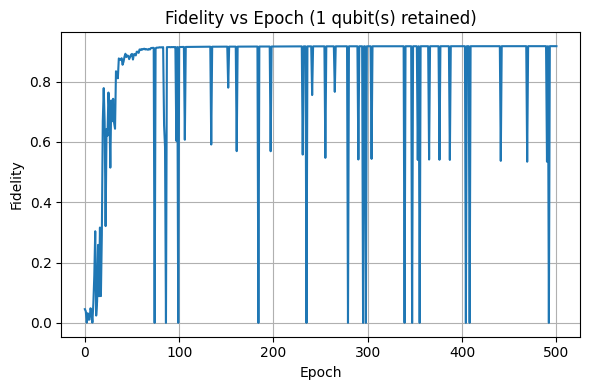

 Final Fidelity with 1 qubit: 0.9174

 Training with 2 qubits retained...


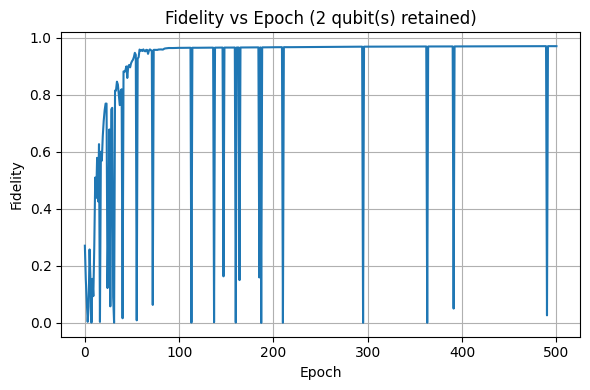

 Final Fidelity with 2 qubits: 0.9713

 Training with 3 qubits retained...


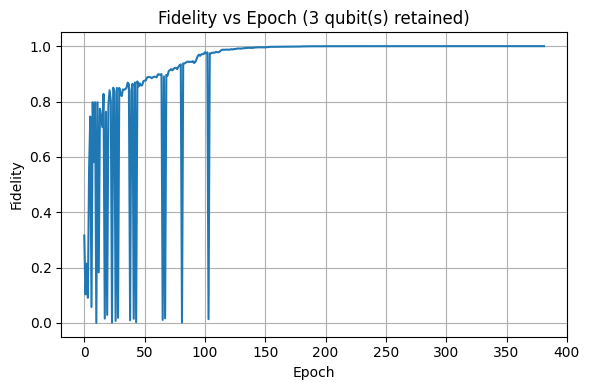

 Final Fidelity with 3 qubits: 1.0000

 Training with 4 qubits retained...


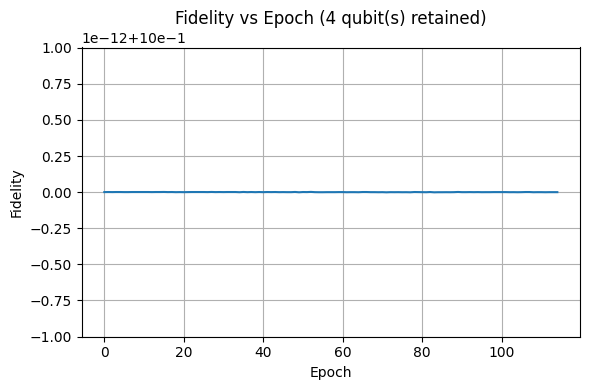

 Final Fidelity with 4 qubits: 1.0000


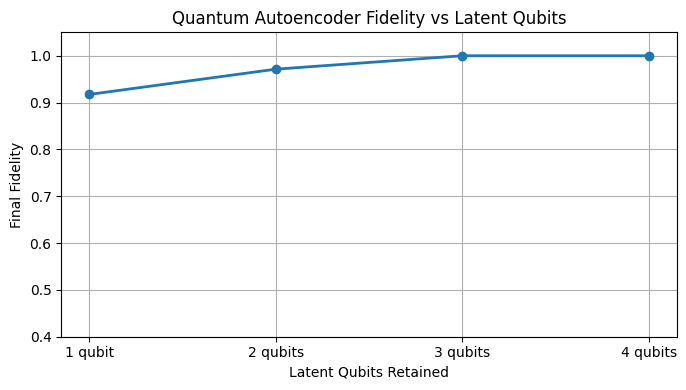

In [109]:
import os
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, state_fidelity
from qiskit.algorithms.optimizers import COBYLA
from sklearn.datasets import fetch_lfw_people
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from utils import normalize_amplitude, build_encoder

# --- Load or generate dataset ---
os.makedirs("data", exist_ok=True)
if not os.path.exists("data/lfw_sample.npy"):
    lfw = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
    X = np.nan_to_num(lfw.data)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=16)
    X_pca = pca.fit_transform(X_scaled)
    np.save("data/lfw_sample.npy", X_pca[0])
    print(" Saved new PCA vector.")
else:
    print("Using saved PCA vector.")

vec = np.load("data/lfw_sample.npy")
vec = normalize_amplitude(vec).astype(complex)
vec /= np.linalg.norm(vec)
original_sv = Statevector(vec)

# --- Training Function ---
def train_qae_variable_latent(vec, retain, trash, reps=2, epochs=500):
    vec = normalize_amplitude(vec).astype(complex)
    vec /= np.linalg.norm(vec)
    original_sv = Statevector(vec)
    encoder = build_encoder(num_qubits=4, reps=reps)
    param_vector = list(encoder.parameters)

    if not param_vector:
        raise ValueError(" Encoder has no parameters.")

    loss_trace = []

    def loss_fn(params):
        try:
            qc = QuantumCircuit(4)
            qc.initialize(vec, range(4))  # Safe initialization

            bound_encoder = encoder.assign_parameters(dict(zip(param_vector, params)))
            qc.append(bound_encoder, range(4))

            for q in trash:
                qc.reset(q)

            qc.append(bound_encoder.inverse(), range(4))

            final_sv = Statevector.from_instruction(qc)

            norm = np.sum(np.abs(final_sv.data)**2)
            if not np.isclose(norm, 1.0, atol=1e-3):
                print(f" State not normalized: norm = {norm}")
                return 1.0

            if np.isnan(final_sv.data).any():
                print(" NaN in statevector!")
                return 1.0

            fid = state_fidelity(original_sv, final_sv)
            loss_trace.append(1 - fid)
            return 1 - fid

        except Exception as e:
            print(" Error in loss_fn:", e)
            return 1.0

    initial_params = np.random.uniform(0, 2 * np.pi, len(param_vector))
    optimizer = COBYLA(maxiter=epochs)

    try:
        opt_result = optimizer.minimize(fun=loss_fn, x0=initial_params)
    except Exception as e:
        raise RuntimeError(f" Optimizer failed: {e}")

    final_params = opt_result.x
    final_fid = 1 - loss_fn(final_params)

    # --- Plot Fidelity ---
    plt.figure(figsize=(6, 4))
    plt.plot([1 - l for l in loss_trace])
    plt.title(f"Fidelity vs Epoch ({len(retain)} qubit(s) retained)")
    plt.xlabel("Epoch")
    plt.ylabel("Fidelity")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    global LAST_ENCODER, LAST_PARAMS, LAST_VEC
    LAST_ENCODER = encoder
    LAST_PARAMS = final_params
    LAST_VEC = vec

    return final_fid

# --- Compression configs ---
configs = {
    "1 qubit": ([0], [1, 2, 3]),
    "2 qubits": ([0, 1], [2, 3]),
    "3 qubits": ([0, 1, 2], [3]),
    "4 qubits": ([0, 1, 2, 3], [])
}

results = {}
for label, (retain, trash) in configs.items():
    print(f"\n Training with {label} retained...")
    fidelity = train_qae_variable_latent(vec, retain=retain, trash=trash, reps=2, epochs=500)
    print(f" Final Fidelity with {label}: {fidelity:.4f}")
    results[label] = fidelity

# --- Final Summary Plot ---
plt.figure(figsize=(7, 4))
plt.plot(list(results.keys()), list(results.values()), marker="o", linewidth=2)
plt.title("Quantum Autoencoder Fidelity vs Latent Qubits")
plt.xlabel("Latent Qubits Retained")
plt.ylabel("Final Fidelity")
plt.ylim(0.4, 1.05)
plt.grid(True)
plt.tight_layout()
plt.show()


📉 MSE (QAE)  : 0.010925
📉 MSE (JPEG): 0.000663


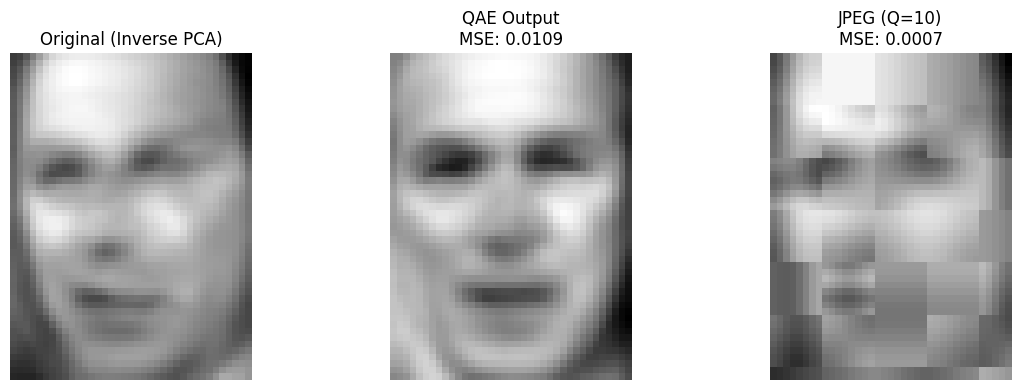

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_lfw_people
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# === Step 1: Load and prepare dataset ===
lfw = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
X = lfw.data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=16)
X_pca = pca.fit_transform(X_scaled)
vec_pca = np.load("data/lfw_sample.npy")  # the 16D input vector

# === Step 2: Reconstruct QAE output vector ===
reconstructed_vec = reconstruct_qae_output(
    vec=vec_pca,
    encoder=LAST_ENCODER,
    params=LAST_PARAMS,
    retain=[0, 1, 2, 3],  # change this for 1, 2, 3 qubit comparisons
    trash=[]
)

# === Step 3: Invert PCA → 1850 → 50×37 images ===
# QAE
qae_scaled = pca.inverse_transform(reconstructed_vec.reshape(1, -1))
qae_img = scaler.inverse_transform(qae_scaled).reshape(50, 37)

# Original
original_scaled = pca.inverse_transform(vec_pca.reshape(1, -1))
original_img = scaler.inverse_transform(original_scaled).reshape(50, 37)

# === Step 4: Generate JPEG-compressed version ===
jpeg_input = (original_img * 255).astype(np.uint8)
cv2.imwrite("images/qae_temp.jpg", jpeg_input, [int(cv2.IMWRITE_JPEG_QUALITY), 10])
jpeg_img = cv2.imread("images/qae_temp.jpg", cv2.IMREAD_GRAYSCALE)
jpeg_img = cv2.resize(jpeg_img, (37, 50)).astype(np.float64) / 255.0  # Normalize

# === Step 5: Compute MSE scores ===
mse_qae = mean_squared_error(original_img.flatten(), qae_img.flatten())
mse_jpeg = mean_squared_error(original_img.flatten(), jpeg_img.flatten())

print(f"📉 MSE (QAE)  : {mse_qae:.6f}")
print(f"📉 MSE (JPEG): {mse_jpeg:.6f}")

# === Step 6: Plot Comparison ===
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(original_img, cmap="gray")
plt.title("Original (Inverse PCA)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(qae_img, cmap="gray")
plt.title(f"QAE Output\nMSE: {mse_qae:.4f}")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(jpeg_img, cmap="gray")
plt.title(f"JPEG (Q=10)\nMSE: {mse_jpeg:.4f}")
plt.axis("off")

plt.tight_layout()
plt.savefig("images/qae_vs_jpeg_vs_original.png", dpi=300)
plt.show()
